In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('../scripts')
from paths import SIMULATED_PATH, SIMULATED_DATA_ROOT
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

### Mnist dataset

In [45]:
mnist_data = tf.keras.datasets.mnist.load_data()
x = {
    'train': mnist_data[0][0],
    'test': mnist_data[1][0]
}
y = {
    'train': mnist_data[0][1],
    'test': mnist_data[1][1]
}

In [46]:
def visualize(data):
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        ax[i // 3, i % 3].imshow(data[i])
        ax[i // 3, i % 3].set_xticks([])
        ax[i // 3, i % 3].set_yticks([])
    plt.show()

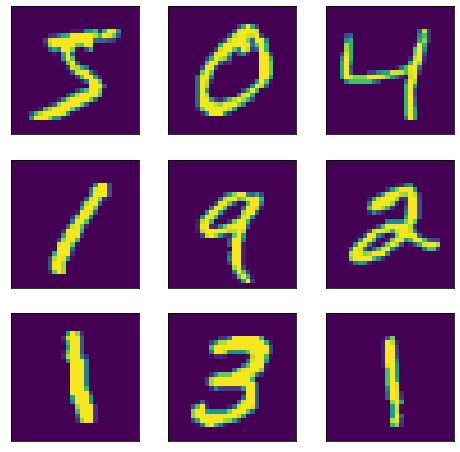

In [47]:
visualize(x['train'])

### Evaluate linear classifier

In [5]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1)
]
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), epochs=999, batch_size=64, callbacks=callbacks)

Epoch 1/999
938/938 [==============================] - 6s 4ms/step - loss: 8.0353 - accuracy: 0.8144 - val_loss: 0.5631 - val_accuracy: 0.8903
Epoch 2/999
938/938 [==============================] - 4s 4ms/step - loss: 0.4155 - accuracy: 0.9110 - val_loss: 0.4042 - val_accuracy: 0.9178
Epoch 3/999
938/938 [==============================] - 4s 4ms/step - loss: 0.2792 - accuracy: 0.9297 - val_loss: 0.3183 - val_accuracy: 0.9328
Epoch 4/999
938/938 [==============================] - 4s 4ms/step - loss: 0.2186 - accuracy: 0.9425 - val_loss: 0.2776 - val_accuracy: 0.9354
Epoch 5/999
938/938 [==============================] - 4s 4ms/step - loss: 0.2085 - accuracy: 0.9454 - val_loss: 0.2885 - val_accuracy: 0.9459
Epoch 00005: early stopping


# Contrastive model

In [282]:
batch_size = 128
temperature = .1

In [289]:
def blur(x):
    a, b = tf.split(x, 2, axis=0)
    if np.random.rand() < .75:
        a = gaussian_filter(a, sigma=np.random.rand())
    if np.random.rand() < .75:
        b = gaussian_filter(b, sigma=np.random.rand())
    return tf.concat([a, b], axis=0)
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-.1, .1), width_factor=(-.1, .1)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.1)
    #tf.keras.layers.Lambda(blur)
])

In [290]:
x_pairs = {}
for type in ['train', 'test']:
    x_pairs[type] = []
    for i in range(0, x[type].shape[0] - batch_size + 1, batch_size):
        x_batch = rescale(x[type][i:i+batch_size])
        x_batch = tf.convert_to_tensor(x_batch)
        x_batch = tf.repeat(x_batch[:, :, :, tf.newaxis], 3, axis=-1)
        x_batch = tf.tile(x_batch, [2, 1, 1, 1])
        x_pairs[type].append(x_batch)
    x_pairs[type] = tf.stack(x_pairs[type])
    x_pairs[type] = tf.random.shuffle(x_pairs[type])

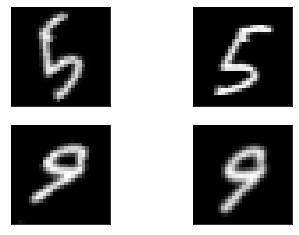

In [291]:
x_aug = {}
train_batch = x_pairs['train'][0]
train_batch_aug = data_augmentation(train_batch)
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(train_batch_aug[0])
ax[0, 1].imshow(train_batch_aug[batch_size])
ax[1, 0].imshow(train_batch_aug[1])
ax[1, 1].imshow(train_batch_aug[batch_size + 1])
for i in range(4):
    ax[i // 2, i % 2].set_xticks([])
    ax[i // 2, i % 2].set_yticks([])
plt.show()

In [292]:
class ContrastiveModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.preprocessing = data_augmentation
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(.5),
            tf.keras.layers.Dense(128, activation='relu')
        ])
        self.training_head = tf.keras.layers.Dense(128)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        
    def call(self, x, training=None):
        if training:
            x = self.preprocessing(x)
        x = self.encoder(x)
        x = self.training_head(x)
        x = self.batch_norm(x)
        z_i, z_j = tf.split(x, 2, axis=0)
        return z_i, z_j

In [293]:
def contrastive_loss(z_i, z_j, temperature=1.0):
    batch_size = tf.shape(z_i)[0]
    labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
    mask = tf.one_hot(tf.range(batch_size), batch_size)
    logits_aa = tf.matmul(z_i, z_i, transpose_b=True) / temperature
    logits_aa -= mask * 1e9
    logits_bb = tf.matmul(z_j, z_j, transpose_b=True) / temperature
    logits_bb -= mask * 1e9
    logits_ab = tf.matmul(z_i, z_j, transpose_b=True) / temperature
    logits_ba = tf.matmul(z_j, z_i, transpose_b=True) / temperature
    loss_a = tf.nn.softmax_cross_entropy_with_logits(labels, tf.concat([logits_ab, logits_aa], 1))
    loss_b = tf.nn.softmax_cross_entropy_with_logits(labels, tf.concat([logits_ba, logits_bb], 1))
    loss = tf.reduce_mean(loss_a + loss_b)
    return loss, logits_ab, labels

In [294]:
optimizer = tf.keras.optimizers.Adam()
temperature = .1
model = ContrastiveModel()
best_test_loss = float('inf')
k = 0
patience = 10
for epoch in range(999):
    train_loss_avg = tf.keras.metrics.Mean()
    test_loss_avg = tf.keras.metrics.Mean()
    for batch in x_pairs['train']:
        with tf.GradientTape() as tape:
            z_i, z_j = model(batch, training=True)
            loss, _, _ = contrastive_loss(z_i, z_j, temperature=temperature)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_loss_avg.update_state(loss)
    for batch in x_pairs['test']:
        z_i, z_j = model(batch, training=False)
        loss, _, _ = contrastive_loss(z_i, z_j, temperature=temperature)
        test_loss_avg.update_state(loss)
    train_loss = train_loss_avg.result()
    test_loss = test_loss_avg.result()
    print(f'Train loss: {train_loss} Test loss: {test_loss}')
    if test_loss < best_test_loss:
        k = 0
        best_test_loss = test_loss
        print('Improved')
        model.save_weights('contrastive_weights.h5')
    else:
        k += 1
        if k >= patience:
            break

Train loss: 81.79779052734375 Test loss: 10.712457656860352
Improved
Train loss: 9.735787391662598 Test loss: 7.232767581939697
Improved
Train loss: 8.840286254882812 Test loss: 5.891907691955566
Improved
Train loss: 8.324990272521973 Test loss: 6.019481658935547
Train loss: 8.067597389221191 Test loss: 5.024805068969727
Improved
Train loss: 7.72116756439209 Test loss: 4.876263618469238
Improved
Train loss: 7.2949323654174805 Test loss: 5.502788066864014
Train loss: 7.067462921142578 Test loss: 4.799975395202637
Improved
Train loss: 6.863137722015381 Test loss: 4.994575023651123
Train loss: 6.761721134185791 Test loss: 5.309876441955566
Train loss: 6.587408065795898 Test loss: 4.64550256729126
Improved
Train loss: 6.425501346588135 Test loss: 4.278831958770752
Improved
Train loss: 6.291229724884033 Test loss: 4.322897911071777
Train loss: 6.207773685455322 Test loss: 3.9261817932128906
Improved
Train loss: 5.965686321258545 Test loss: 3.7188169956207275
Improved
Train loss: 5.778391361

In [310]:
model.load_weights('contrastive_weights.h5')
test_loss_avg = tf.keras.metrics.Mean()
for batch in x_pairs['test']:
    z_i, z_j = model(batch)
    loss, _, _ = contrastive_loss(z_i, z_j, temperature=temperature)
    test_loss_avg.update_state(loss)
print('Test loss: ' + str(test_loss_avg.result().numpy()))

Test loss: 0.38608718


### Train supervised head

In [311]:
class ContrastiveProbe(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.trainable = False
        self.supervised_head = tf.keras.models.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        
    def call(self, x):
        x = self.model.encoder(x)
        return self.supervised_head(x)

In [312]:
x_probe = {}
for type in ['train', 'test']:
    x_probe[type] = tf.repeat(x[type][:, :, :, tf.newaxis], 3, axis=-1)
    x_probe[type] = rescale(x_probe[type])

In [313]:
supervised = ContrastiveProbe(model)
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.ModelCheckpoint('contrastive_probe.h5', save_best_only=True)
]
supervised.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
supervised.fit(x_probe['train'], y['train'], validation_data=(x_probe['test'], y['test']), batch_size=batch_size, epochs=10, callbacks=callbacks)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 1.8018 - accuracy: 0.4316 - val_loss: 0.7065 - val_accuracy: 0.8706
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7262 - accuracy: 0.8226 - val_loss: 0.4733 - val_accuracy: 0.8991
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.5604 - accuracy: 0.8517 - val_loss: 0.3830 - val_accuracy: 0.9111
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4979 - accuracy: 0.8632 - val_loss: 0.3396 - val_accuracy: 0.9166
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4555 - accuracy: 0.8674 - val_loss: 0.3086 - val_accuracy: 0.9204
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4232 - accuracy: 0.8753 - val_loss: 0.2839 - val_accuracy: 0.9254
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4130 - accuracy: 0.8777 - val_loss: 0.2700 - val_accuracy: 0.9270
Epoch 

In [314]:
supervised.load_weights('contrastive_probe.h5')
loss, acc = supervised.evaluate(x_probe['test'], y['test'])
print(f'Accuracy: {acc:.3f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.2443 - accuracy: 0.9318
Accuracy: 0.932


### Also try randomly initialized encoder

In [315]:
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K
rand_model = ContrastiveModel()
rand_probe = ContrastiveProbe(rand_model)
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.ModelCheckpoint('contrastive_probe_randomly_initialized.h5', save_best_only=True)
]
rand_probe.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rand_probe.fit(x_probe['train'], y['train'], validation_data=(x_probe['test'], y['test']), batch_size=batch_size, epochs=10, callbacks=callbacks)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 2.2064 - accuracy: 0.2434 - val_loss: 1.9387 - val_accuracy: 0.7226
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 1.8800 - accuracy: 0.5225 - val_loss: 1.6868 - val_accuracy: 0.7671
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 1.6773 - accuracy: 0.5579 - val_loss: 1.5080 - val_accuracy: 0.7762
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 1.5442 - accuracy: 0.5655 - val_loss: 1.3809 - val_accuracy: 0.7837
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 1.4496 - accuracy: 0.5796 - val_loss: 1.2845 - val_accuracy: 0.7879
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 1.3815 - accuracy: 0.5869 - val_loss: 1.2113 - val_accuracy: 0.7934
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 1.3374 - accuracy: 0.5914 - val_loss: 1.1502 - val_accuracy: 0.7949
Epoch 

In [316]:
rand_probe.load_weights('contrastive_probe_randomly_initialized.h5')
loss, acc = rand_probe.evaluate(x_probe['test'], y['test'])
print(f'Accuracy: {acc:.3f}')

313/313 [==============================] - 1s 3ms/step - loss: 1.0363 - accuracy: 0.7987
Accuracy: 0.799


### Also try unfrozen

In [317]:
unfrozen_model = ContrastiveModel()
unfrozen_probe = ContrastiveProbe(model)
unfrozen_probe.model.trainable = True
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.ModelCheckpoint('contrastive_probe_unfrozen.h5', save_best_only=True)
]
unfrozen_probe.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
unfrozen_probe.fit(x_probe['train'], y['train'], validation_data=(x_probe['test'], y['test']), batch_size=batch_size, epochs=10, callbacks=callbacks)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.9965 - accuracy: 0.6808 - val_loss: 0.0945 - val_accuracy: 0.9701
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1544 - accuracy: 0.9508 - val_loss: 0.0597 - val_accuracy: 0.9815
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1196 - accuracy: 0.9620 - val_loss: 0.0522 - val_accuracy: 0.9825
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0931 - accuracy: 0.9707 - val_loss: 0.0422 - val_accuracy: 0.9862
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0869 - accuracy: 0.9709 - val_loss: 0.0368 - val_accuracy: 0.9883
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0775 - accuracy: 0.9762 - val_loss: 0.0397 - val_accuracy: 0.9865
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0678 - accuracy: 0.9787 - val_loss: 0.0331 - val_accuracy: 0.9891
Epoch 

In [306]:
unfrozen_probe.load_weights('contrastive_probe_unfrozen.h5')
loss, acc = unfrozen_probe.evaluate(x_probe['test'], y['test'])
print(f'Accuracy: {acc:.3f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0352 - accuracy: 0.9891
Accuracy: 0.989


# Debugging

<b>Why is random initialization accuracy so high?</b>

In [9]:
class TestModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu')
        ])
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.encoder(x)
        return self.output_layer(x)

Regular training accuracy should be high

In [10]:
model = TestModel()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 4.2513 - accuracy: 0.8266 - val_loss: 0.5034 - val_accuracy: 0.9164
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3702 - accuracy: 0.9276 - val_loss: 0.2621 - val_accuracy: 0.9374
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2065 - accuracy: 0.9461 - val_loss: 0.2009 - val_accuracy: 0.9449
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1575 - accuracy: 0.9571 - val_loss: 0.1874 - val_accuracy: 0.9546
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1469 - accuracy: 0.9586 - val_loss: 0.1748 - val_accuracy: 0.9552
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1212 - accuracy: 0.9660 - val_loss: 0.1367 - val_accuracy: 0.9646
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1173 - accuracy: 0.9690 - val_loss: 0.1471 - val_accuracy:

Frozen xavier initialized encoder accuracy should be lower

In [11]:
model = TestModel()
model.encoder.trainable = False
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 19.5067 - accuracy: 0.5377 - val_loss: 2.9179 - val_accuracy: 0.7918
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.4774 - accuracy: 0.7942 - val_loss: 1.6057 - val_accuracy: 0.8062
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5255 - accuracy: 0.8005 - val_loss: 1.1928 - val_accuracy: 0.8111
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1500 - accuracy: 0.8015 - val_loss: 0.9701 - val_accuracy: 0.8065
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0135 - accuracy: 0.7985 - val_loss: 0.8489 - val_accuracy: 0.8219
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9866 - accuracy: 0.7948 - val_loss: 1.0050 - val_accuracy: 0.7917
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9825 - accuracy: 0.7924 - val_loss: 0.8673 - val_accuracy

Frozen zero initialized encoder accuracy should be random

In [27]:
model = TestModel()
model(x['train'])
for layer in model.encoder.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w, b = weights
        layer.set_weights([tf.zeros(w.shape), tf.zeros(b.shape)])
model.encoder.trainable = False
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3019 - accuracy: 0.1078 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3011 - accuracy: 0.1131 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3015 - accuracy: 0.1127 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3016 - accuracy: 0.1118 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3008 - accuracy: 0.1154 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3016 - accuracy: 0.1104 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3016 - accuracy: 0.1121 - val_loss: 2.3011 - val_accuracy: